# Artem Matveenkov test task, supply analyst role

Assumptions:
- all data are correct, there are no noise inside changes of supplies
- we strictly want to decrease pricing. It should be fine to try to increase it as well, but I skipped this part because of optimizing execution speed, I guess you need to create a copy of dataframe in case you want to increase prices as well
- no info about forecasted_profit is shown. I assume this info is internal and shouldn't be used by suppliers

I've spend about three hours total to do this script

In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
from inspect import cleandoc

In [6]:
source_data = pd.read_parquet('reprice_data.parquet')
source_data.head(10)

,row_id,order_date,order_status,booked_supplier,booked_supplier_feed,selling_price,cancellation_probability,order_id,reprice_supplier,reprice_supplier_feed,source_price,source_commission,forecasted_profit
197,5178704,18052,cancelled,NJRE,IEXJ,196.366837,0.0360,18356025,NJRE,IEXJ,208.029756,0.07,9.704634
273,5178784,18051,completed,HYTR,NYUV,257.315753,0.0333,54848565,FMNM,NYUV,241.097949,0.00,14.084390
276,5178787,18051,completed,HYTR,NYUV,257.315753,0.0333,54848565,VXRN,RLLU,258.678834,0.06,15.750244
278,5178789,18051,completed,HYTR,NYUV,257.315753,0.0333,54848565,CBBU,NYUV,244.869293,0.00,15.800244
283,5178794,18051,completed,HYTR,NYUV,257.315753,0.0333,54848565,VPXO,NYUV,233.555259,0.00,22.127561
284,5178795,18051,completed,HYTR,NYUV,257.315753,0.0333,54848565,HYTR,NYUV,233.448017,0.00,23.235854
285,5178796,18051,completed,HYTR,NYUV,257.315753,0.0333,54848565,HYTR,NYUV,233.448017,0.00,23.235854
511,5179021,18051,completed,NJRE,RVNM,257.052486,0.8388,87098305,NJRE,RVNM,257.052485,0.09,34.148780
582,5179573,18053,completed,NJRE,IEXJ,167.402213,0.0150,65949964,NJRE,IEXJ,162.386078,0.07,21.656829
649,5179641,18053,completed,NJRE,IEXJ,167.402213,0.0150,65949964,NJRE,HHLV,185.933649,0.09,3.908780


In [7]:
def changes_analysis(df, supplier_name, price_change, output='text'):
    """Form information about changes of supplies

    Arguments:
    df -- a dataframe with reprice data
    supplier_name -- code of supplier from column 'reprice_supplier'
    price_change -- percentage of changing price, use negative value for decreasing one
    Keyword arguments:
    output -- options 'text' and 'object' are available
        text returns a string with actual info for specific price change
        object returns a dictionary with parametres of changes
    """
    winning_prices = df.groupby('order_id')['source_price'].min().reset_index() 
    best_supplier_prices = df[df['reprice_supplier'] == supplier_name] \
        .groupby('order_id')['source_price'].min().reset_index()

    best_supplier_prices = best_supplier_prices.merge(df[df['reprice_supplier'] == supplier_name],
                          how='left',
                          on=['order_id', 'source_price'])

    # dropping prices by percentage
    # float precision error occurs while price doesn't change - very small numbers are in change_price instead of 0
    best_supplier_prices['changed_price'] = best_supplier_prices['source_price']
    if price_change != 0:
        best_supplier_prices['changed_price'] = best_supplier_prices['source_price'] * (100.0 + price_change) / 100.0
        
    # positive when the price decreases, negative when the price increases
    best_supplier_prices['difference'] = best_supplier_prices['source_price'] - best_supplier_prices['changed_price']

    relevant_rows = ['order_id', 'source_price', 'changed_price', 'difference', 'order_status', 'forecasted_profit']
    best_supplier_prices = best_supplier_prices[relevant_rows]

    merged = best_supplier_prices.merge(winning_prices, 
                                         how='left', 
                                         on='order_id', 
                                         suffixes=('_target', '_winner'))

    merged['forecasted_profit_changed'] = merged['forecasted_profit'] + merged['difference']

    merged['is_winner_default'] = merged['source_price_target'] <= merged['source_price_winner']
    merged['is_winner_changed'] = merged['changed_price'] <= merged['source_price_winner']

    result = {'price_change': price_change,
              'default_wr': merged['is_winner_default'].sum() / len(merged) * 100,
              'changed_wr': merged['is_winner_changed'].sum() / len(merged) * 100,
              'default_revenue': merged[(merged['is_winner_default']) & (merged['order_status'] == 'completed')].sum()['source_price_target'],
              'changed_revenue': merged[(merged['is_winner_changed']) & (merged['order_status'] == 'completed')].sum()['changed_price']}
    if output == 'text':
        return cleandoc(f'''
            price change: \t\t{price_change}%
            default winning rate:\t{result['default_wr']:.4f}%
            changed price winning rate:\t{result['changed_wr']:.4f}%
            default revenue:\t\t{result['default_revenue']:.2f} MYS
            changed price revenue:\t{result['changed_revenue']:.2f} MYS
            ''')
    if output == 'object':
        return result

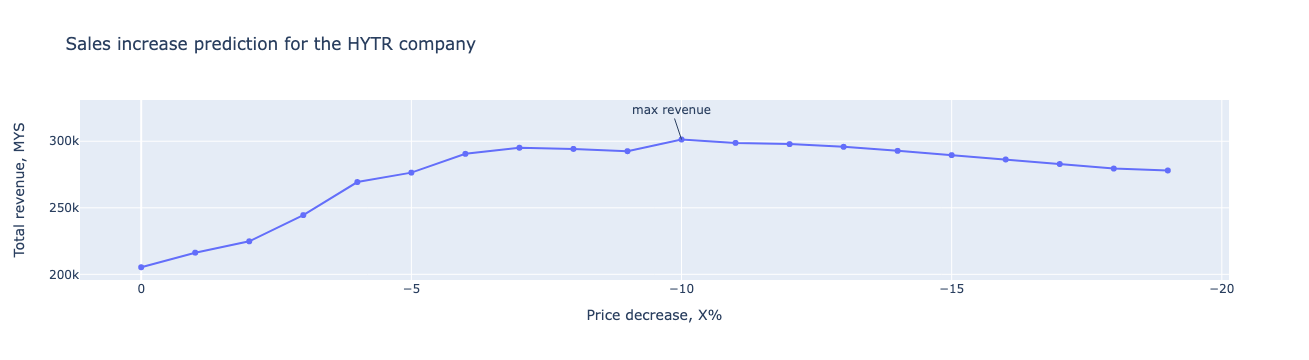

,price_change,default_wr,changed_wr,default_revenue,changed_revenue,difference_revenue,percentage_revenue
0,0,61.65,61.65,205317.51,205317.51,0.00,0.00
1,-1,61.65,66.54,205317.51,216279.87,10962.36,5.34
2,-2,61.65,70.68,205317.51,224801.75,19484.24,9.49
3,-3,61.65,76.50,205317.51,244496.89,39179.37,19.08
4,-4,61.65,81.58,205317.51,269337.03,64019.52,31.18
5,-5,61.65,85.53,205317.51,276416.41,71098.89,34.63
6,-6,61.65,89.29,205317.51,290536.19,85218.67,41.51
7,-7,61.65,91.73,205317.51,295107.89,89790.38,43.73
8,-8,61.65,93.05,205317.51,294223.09,88905.58,43.30
9,-9,61.65,93.61,205317.51,292516.59,87199.08,42.47


In [8]:
# for example, parametres like
    # supplier_name = 'HYTR'
    # min_price_decrease = 0
    # max_price_decrease = 20
    # decreasing_step = 1
# will generate a table with 20 rows, showing (0%, 1%,... 20%) price decrease effects
# adjust them for further analysis

# ----- put your variables below -----
supplier_name = 'HYTR'
min_price_decrease = 0
max_price_decrease = 20
decreasing_step = 1
# ----- end of parametres, please do not change the further code with no purpose -----

# drawing graph
df_graph = pd.DataFrame.from_dict([
        changes_analysis(source_data, supplier_name, i, output='object') 
        for i in np.arange(-min_price_decrease, -max_price_decrease, -decreasing_step)
    ]
)
df_graph['difference_revenue'] = df_graph['changed_revenue'] - df_graph['default_revenue']
df_graph['percentage_revenue'] = (df_graph['changed_revenue'] / df_graph['default_revenue'] - 1) * 100
df_graph = df_graph.round(2)

fig = px.scatter(df_graph, 
                 x='price_change', 
                 y='changed_revenue', 
                 title=f'Sales increase prediction for the {supplier_name} company',
                 hover_data=["difference_revenue", "percentage_revenue"],
                 labels={
                        "price_change": "Price decrease, X% ",
                        "changed_revenue": "Total revenue, MYS ",
                        "difference_revenue": "Extra revenue, MYS ",
                         "percentage_revenue": "Revenue change, % "
                 },)
fig['layout']['xaxis']['autorange'] = 'reversed'
fig.add_annotation(x=df_graph.iloc[df_graph['changed_revenue'].idxmax()]['price_change'], 
                   y=df_graph.iloc[df_graph['changed_revenue'].idxmax()]['changed_revenue'],
                   text='max revenue')
fig.update_traces(mode="markers+lines")
fig.show()

df_graph